In [3]:
from __future__ import print_function
import collections
import mxnet as mx
import numpy as np
from mxnet import nd, autograd
from matplotlib import pyplot as plt

In [2]:
!pip install mxnet

     |████████████████████████████████| 46.9 MB 45 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [22]:
config = {
    "num_hidden_layers": 2,
    "num_hidden_units": 1200,
    "batch_size": 128,
    "epochs": 10,
    "learning_rate": 0.001,
    "num_samples": 1,
    "pi": 0.25,
    "sigma_p": 1.0,
    "sigma_p1": 0.75,
    "sigma_p2": 0.1,
}

In [23]:
ctx = mx.cpu()

In [24]:
# load mnist data 
# process the pixels by dividing by 126
def transform(data, label):
    return data.astype(np.float32)/126.0, label.astype(np.float32)

mnist = mx.test_utils.get_mnist()
num_inputs = 784
num_outputs = 10
batch_size = config['batch_size']

train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

num_train = sum([batch_size for i in train_data])
num_batches = num_train / batch_size

In [25]:
#relu activation function
def relu(X):
    return nd.maximum(X, nd.zeros_like(X))

In [26]:
# MLP

num_layers = config['num_hidden_layers']

# define function for evaluating MLP
def net(X, layer_params):
    layer_input = X
    for i in range(len(layer_params) // 2 - 2):
        h_linear = nd.dot(layer_input, layer_params[2*i]) + layer_params[2*i + 1]
        layer_input = relu(h_linear)
    # last layer without ReLU
    output = nd.dot(layer_input, layer_params[-2]) + layer_params[-1]
    return output

# define network weight shapes
layer_param_shapes = []
num_hidden = config['num_hidden_units']
for i in range(num_layers + 1):
    if i == 0: # input layer
        W_shape = (num_inputs, num_hidden)
        b_shape = (num_hidden,)
    elif i == num_layers: # last layer
        W_shape = (num_hidden, num_outputs)
        b_shape = (num_outputs,)
    else: # hidden layers
        W_shape = (num_hidden, num_hidden)
        b_shape = (num_hidden,)
    layer_param_shapes.extend([W_shape, b_shape])

In [27]:
def log_softmax_likelihood(yhat_linear, y):
    return nd.nansum(y * nd.log_softmax(yhat_linear), axis=0, exclude=True)

In [28]:
LOG2PI = np.log(2.0 * np.pi)

def log_gaussian(x, mu, sigma):
    return -0.5 * LOG2PI - nd.log(sigma) - (x - mu) ** 2 / (2 * sigma ** 2)

def gaussian_prior(x):
    sigma_p = nd.array([config['sigma_p']], ctx=ctx)

    return nd.sum(log_gaussian(x, 0., sigma_p))

In [29]:
def gaussian(x, mu, sigma):
    scaling = 1.0 / nd.sqrt(2.0 * np.pi * (sigma ** 2))
    bell = nd.exp(- (x - mu) ** 2 / (2.0 * sigma ** 2))

    return scaling * bell

def scale_mixture_prior(x):
    sigma_p1 = nd.array([config['sigma_p1']], ctx=ctx)
    sigma_p2 = nd.array([config['sigma_p2']], ctx=ctx)
    pi = config['pi']

    first_gaussian = pi * gaussian(x, 0., sigma_p1)
    second_gaussian = (1 - pi) * gaussian(x, 0., sigma_p2)

    return nd.log(first_gaussian + second_gaussian)

In [31]:
# combined loss function i.e. expected lower bound
def combined_loss(output, label_one_hot, params, mus, sigmas, log_prior, log_likelihood):

    # Calculate data likelihood
    log_likelihood_sum = nd.sum(log_likelihood(output, label_one_hot))

    # Calculate prior
    log_prior_sum = sum([nd.sum(log_prior(param)) for param in params])

    # Calculate variational posterior
    log_var_posterior_sum = sum([nd.sum(log_gaussian(params[i], mus[i], sigmas[i])) for i in range(len(params))])

    # Calculate total loss
    return 1.0 / num_batches * (log_var_posterior_sum - log_prior_sum) - log_likelihood_sum

In [32]:
# Optimizer using vanilla stochastic gradient descent
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [33]:
def evaluate_accuracy(data_iterator, net, layer_params):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        output = net(data, layer_params)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [34]:
weight_scale = .1 
rho_offset = -3  

# initialize variational parameters; mean and variance for each weight
mus = []
rhos = []

for shape in layer_param_shapes:
    mu = nd.random_normal(shape=shape, ctx=ctx, scale=weight_scale)
    rho = rho_offset + nd.zeros(shape=shape, ctx=ctx)
    mus.append(mu)
    rhos.append(rho)

variational_params = mus + rhos

In [35]:
for param in variational_params:
    param.attach_grad()

In [36]:
# main training loop
# sample epsilon from standard multivariate normal
def sample_epsilons(param_shapes):
    epsilons = [nd.random_normal(shape=shape, loc=0., scale=1.0, ctx=ctx) for shape in param_shapes]
    return epsilons

In [37]:
def softplus(x):
    return nd.log(1. + nd.exp(x))

def transform_rhos(rhos):
    return [softplus(rho) for rho in rhos]

In [38]:
def transform_gaussian_samples(mus, sigmas, epsilons):
    samples = []
    for j in range(len(mus)):
        samples.append(mus[j] + sigmas[j] * epsilons[j])
    return samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Epoch 0. Loss: 12969.159654945288, Train_acc 0.95753336, Test_acc 0.9562
Epoch 1. Loss: 12939.27437858649, Train_acc 0.96965, Test_acc 0.9656
Epoch 2. Loss: 12930.008294334277, Train_acc 0.9763167, Test_acc 0.9712
Epoch 3. Loss: 12921.092213981665, Train_acc 0.98003334, Test_acc 0.9714
Epoch 4. Loss: 12915.27612438075, Train_acc 0.983, Test_acc 0.9757
Epoch 5. Loss: 12907.24484807865, Train_acc 0.98578334, Test_acc 0.9766
Epoch 6. Loss: 12901.624205139342, Train_acc 0.9870333, Test_acc 0.9788
Epoch 7. Loss: 12895.657805616007, Train_acc 0.98931664, Test_acc 0.9796
Epoch 8. Loss: 12889.804193604035, Train_acc 0.9903333, Test_acc 0.9799
Epoch 9. Loss: 12883.81643559353, Train_acc 0.99193335, Test_acc 0.98


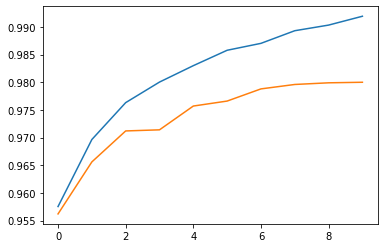

In [39]:
epochs = config['epochs']
learning_rate = config['learning_rate']
smoothing_constant = .01
train_acc = []
test_acc = []
losses = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)

        with autograd.record():
            # sample epsilons from standard normal
            epsilons = sample_epsilons(layer_param_shapes)

            # compute softplus for variance
            sigmas = transform_rhos(rhos)

            # obtain a sample from q(w|theta) by transforming the epsilons
            layer_params = transform_gaussian_samples(mus, sigmas, epsilons)

            # forward-propagate the batch
            output = net(data, layer_params)

            # calculate the loss
            loss = combined_loss(output, label_one_hot, layer_params, mus, sigmas, gaussian_prior, log_softmax_likelihood)

        # backpropagate for gradient calculation
        loss.backward()

        # apply stochastic gradient descent to variational parameters
        SGD(variational_params, learning_rate)

        # calculate moving loss for monitoring convergence
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)


    test_accuracy = evaluate_accuracy(test_data, net, mus)
    train_accuracy = evaluate_accuracy(train_data, net, mus)
    train_acc.append(np.asscalar(train_accuracy))
    test_acc.append(np.asscalar(test_accuracy))
    losses.append(np.asscalar(moving_loss))
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, moving_loss, train_accuracy, test_accuracy))

plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

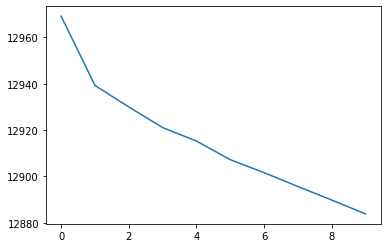

In [40]:
plt.plot(losses)
plt.show()